# Seminarska naloga 2

# 1. OPIS IN OBDELAVA PODATKOVNE MNOŽICE

In [17]:
import pandas as pd
import numpy as np

red_wine_df = pd.read_csv("winequality-red.csv", delimiter=';')
white_wine_df = pd.read_csv("winequality-white.csv", delimiter=';')

red_wine_df['type'] = 1
white_wine_df['type'] = 0

combined_wine_df = pd.concat([red_wine_df, white_wine_df], ignore_index=True)

cols = ['type'] + [col for col in combined_wine_df if col != 'type']
combined_wine_df = combined_wine_df[cols]

shuffled_wine_df = combined_wine_df.sample(frac=1, random_state = 42).reset_index(drop=True)

shuffled_wine_df.to_csv('winequality.csv', index=False)

In [18]:
wine_data = ((pd.read_csv("winequality.csv", delimiter=',')).drop_duplicates()).reset_index(drop=True)

cols = list(wine_data.columns)
x_cols = cols[:-1]
y_cols = cols[-1]

X = wine_data[x_cols]
y = wine_data[y_cols]

print(X)
print(y)

      type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0        0            7.0              0.17         0.74            12.8   
1        1            7.7              0.64         0.21             2.2   
2        0            6.8              0.39         0.34             7.4   
3        0            6.3              0.28         0.47            11.2   
4        0            7.4              0.35         0.20            13.9   
...    ...            ...               ...          ...             ...   
5315     0            5.9              0.26         0.24             2.4   
5316     0            8.0              0.34         0.49             9.0   
5317     0            5.6              0.28         0.27             3.9   
5318     0            6.4              0.37         0.20             5.6   
5319     0            6.5              0.26         0.50             8.0   

      chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0         

In [19]:
import random
import warnings

warnings.filterwarnings('ignore')

def generate_random_numbers(seed, total_numbers=500, range_start=0, range_end=5319):
    random.seed(seed)
    return random.sample(range(range_start, range_end + 1), total_numbers)

ind_col_to_rem = sorted(generate_random_numbers(18, 5, 1, 11))

X_rem = X.copy()

for j in ind_col_to_rem:
    col_name = x_cols[j]
    seed = 18 * j
    random_numbers = generate_random_numbers(seed)
    for num in random_numbers:
        (X_rem[col_name])[num] = float('nan')

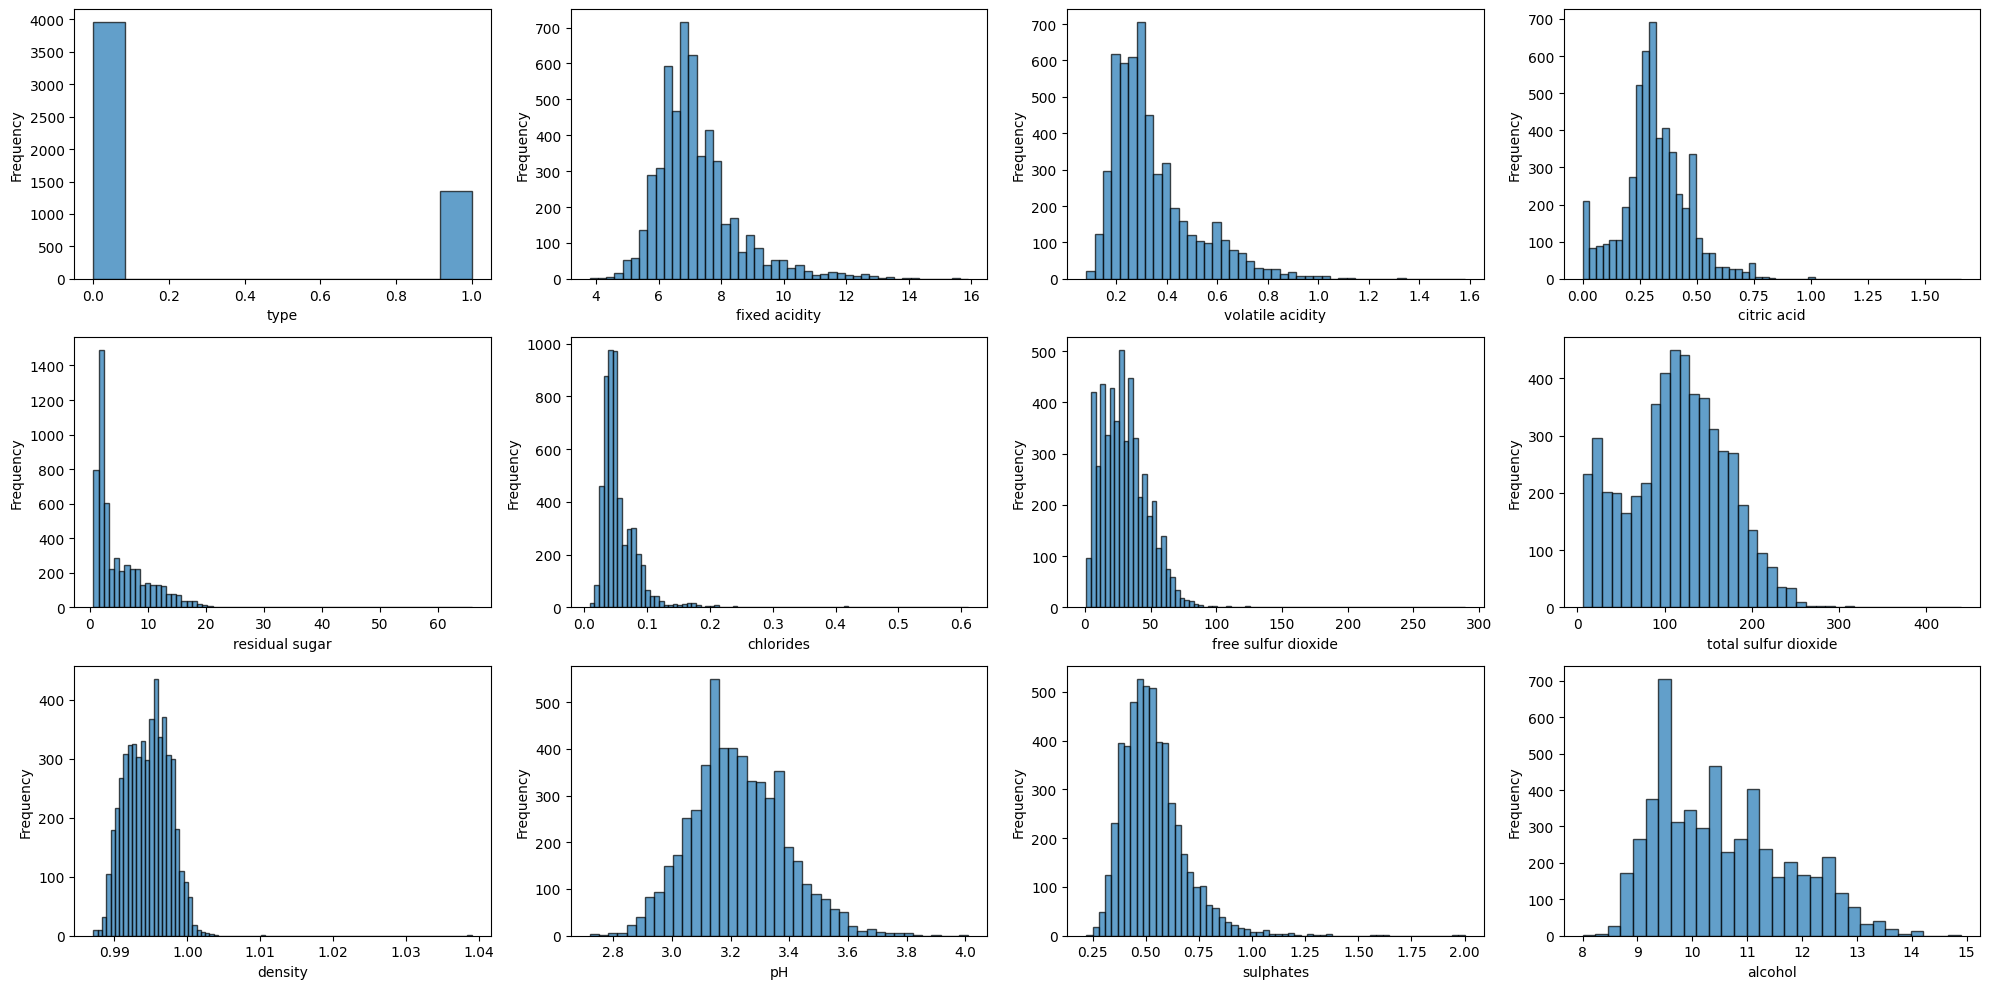

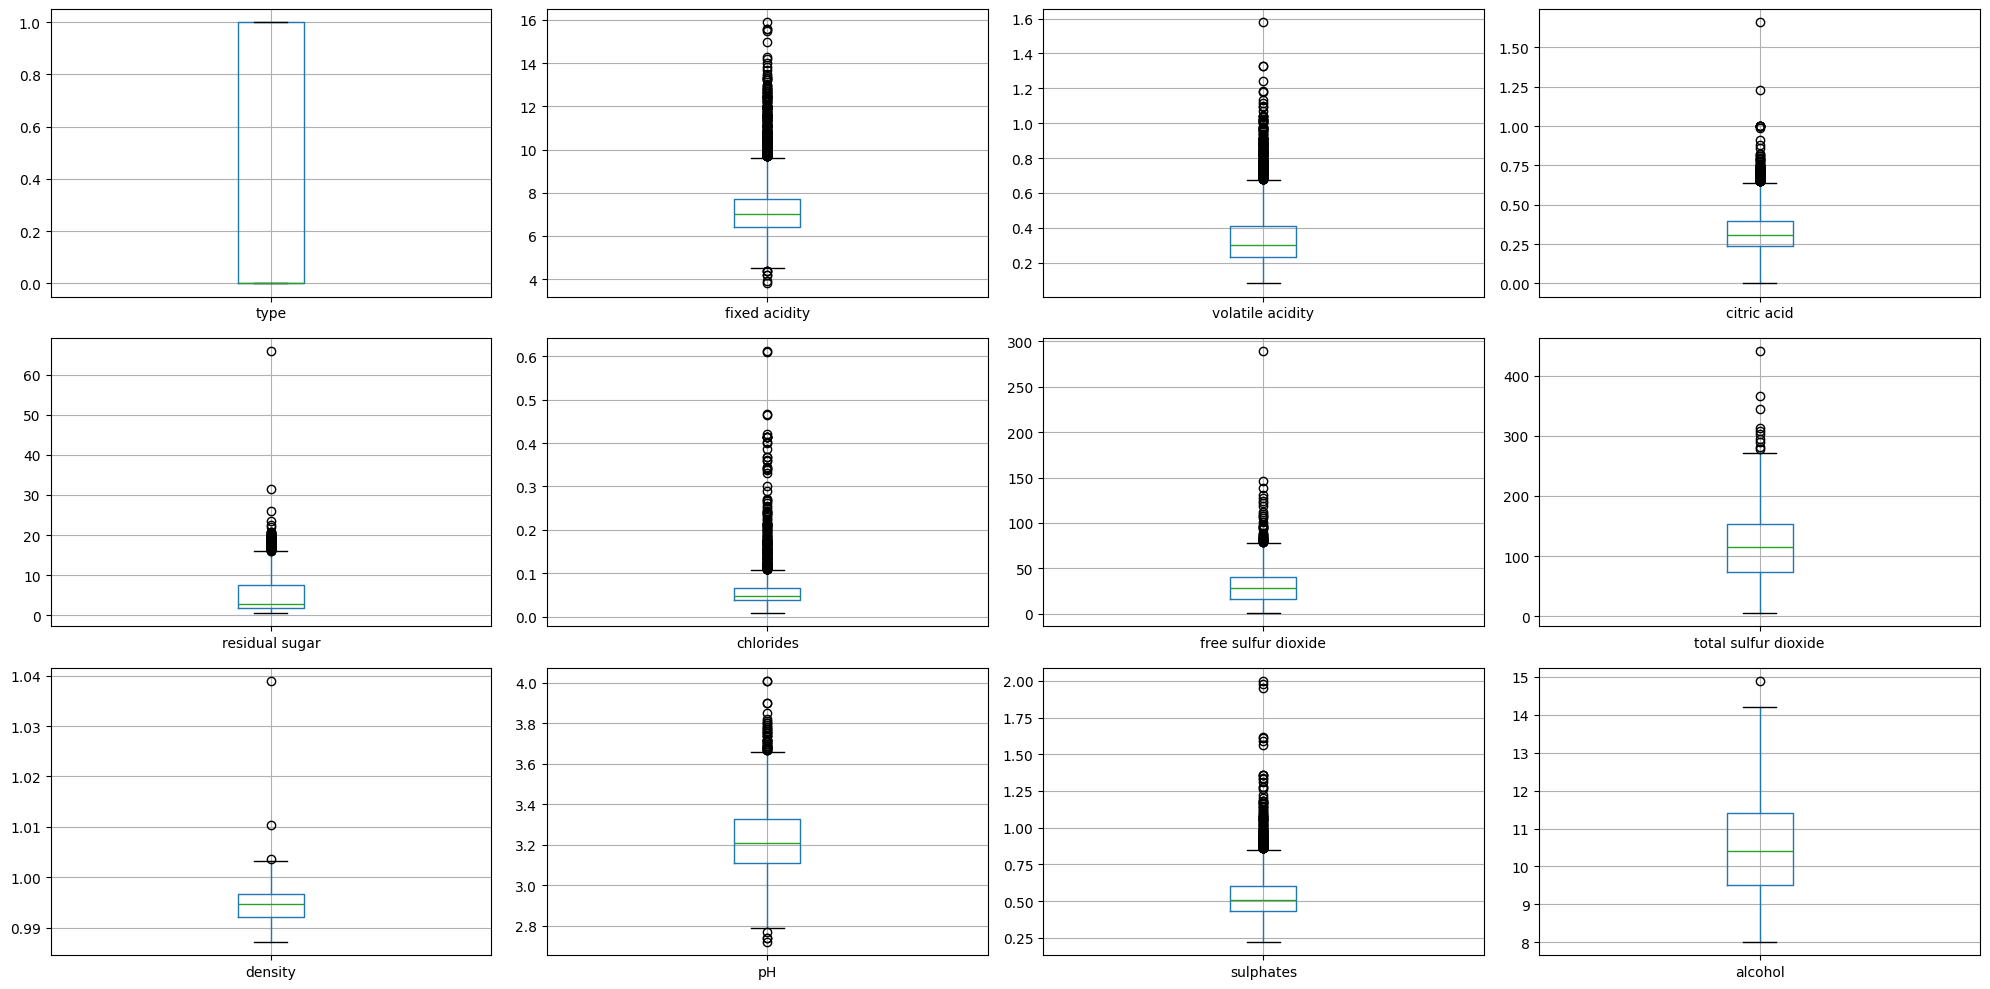

In [20]:
import matplotlib.pyplot as plt

def optimal_bins(data):
    bin_edges = np.histogram_bin_edges(data, bins='scott')
    return len(bin_edges) - 1

num_columns = len(X.columns)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, column in enumerate(X.columns):
    bins = optimal_bins(X[column])
    bins_min = min(bins, 200)
    X[column].plot.hist(bins=bins_min, ax=axes[i], alpha=0.7, edgecolor='black')
    axes[i].set_xlabel(column)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, column in enumerate(X.columns):
    X.boxplot(column=column, ax=axes[i]) 

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [21]:
val_count = y.value_counts()
print(val_count)

quality
6    2323
5    1752
7     856
4     206
8     148
3      30
9       5
Name: count, dtype: int64


In [22]:
from scipy.stats import zscore

def clean_outliers(X_train, y_train):
    z_scores = np.abs(zscore(X_train))
    cols = X_train.columns

    threshold = 3
    mask = (z_scores < threshold).all(axis=1)

    X_cleaned = []
    y_cleaned = []

    for j in range(len(mask)):
        if mask[j]:
            X_cleaned.append([X_train[cols[i]][j] for i in range(len(X_train.columns))])
            y_cleaned.append([y_train[j]])
        else:
            continue
        
    X_cleaned = pd.DataFrame(X_cleaned, columns=cols)
    y_cleaned = pd.DataFrame(y_cleaned, columns=["quality"])
    
    return X_cleaned, y_cleaned

In [23]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import pickle

def stratified_k_fold(X, y, imp=True):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []

    X_np = X.to_numpy()
    y_np = y.to_numpy()

    for _, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y_np[train_index], y_np[test_index]

        if imp:

            imputer = KNNImputer(n_neighbors=5)
            X_train_imputed = imputer.fit_transform(X_train)
            X_test_imputed = imputer.transform(X_test)

            X_train_imputed = pd.DataFrame(X_train_imputed, columns=X.columns)
            X_test_imputed = pd.DataFrame(X_test_imputed, columns=X.columns)

            X_train_imputed, y_train = clean_outliers(X_train_imputed, y_train)

            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train_imputed)
            X_test_scaled = scaler.transform(X_test_imputed)

            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

            y_train = pd.DataFrame(y_train, columns=["quality"])
            y_test = pd.DataFrame(y_test, columns=["quality"])

            X_train_list.append(X_train_scaled)
            X_test_list.append(X_test_scaled)
            y_train_list.append(y_train)
            y_test_list.append(y_test)

            with open('X_train_list_rem.pkl', 'wb') as f:
                pickle.dump(X_train_list, f) 

            with open('X_test_list_rem.pkl', 'wb') as f:
                pickle.dump(X_test_list, f) 
            
            with open('y_train_list_rem.pkl', 'wb') as f:
                pickle.dump(y_train_list, f) 
        
            with open('y_test_list_rem.pkl', 'wb') as f:
                pickle.dump(y_test_list, f) 


        else:

            X_train = pd.DataFrame(X_train, columns=X.columns)
            X_test = pd.DataFrame(X_test, columns=X.columns)

            X_train, y_train = clean_outliers(X_train, y_train)

            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)
 
            y_train = pd.DataFrame(y_train, columns=["quality"])
            y_test = pd.DataFrame(y_test, columns=["quality"])

            X_train_list.append(X_train_scaled)
            X_test_list.append(X_test_scaled)
            y_train_list.append(y_train)
            y_test_list.append(y_test)
            
            with open('X_train_list.pkl', 'wb') as f:
                pickle.dump(X_train_list, f) 

            with open('X_test_list.pkl', 'wb') as f:
                pickle.dump(X_test_list, f) 
            
            with open('y_train_list.pkl', 'wb') as f:
                pickle.dump(y_train_list, f) 
        
            with open('y_test_list.pkl', 'wb') as f:
                pickle.dump(y_test_list, f) 

    print(f"---------------------------stratified_k_fold imputer = {imp} DONE---------------------------")


stratified_k_fold(X_rem, y, True)
stratified_k_fold(X, y, False)

---------------------------stratified_k_fold imputer = True DONE---------------------------
---------------------------stratified_k_fold imputer = False DONE---------------------------


In [24]:
with open('X_train_list_rem.pkl', 'rb') as f:
    X_train_list_rem = pickle.load(f)

with open('X_test_list_rem.pkl', 'rb') as f:
    X_test_list_rem = pickle.load(f)

with open('y_train_list_rem.pkl', 'rb') as f:
    y_train_list_rem = pickle.load(f)

with open('y_test_list_rem.pkl', 'rb') as f:
    y_test_list_rem = pickle.load(f)


with open('X_train_list.pkl', 'rb') as f:
    X_train_list = pickle.load(f)

with open('X_test_list.pkl', 'rb') as f:
    X_test_list = pickle.load(f)

with open('y_train_list.pkl', 'rb') as f:
    y_train_list = pickle.load(f)

with open('y_test_list.pkl', 'rb') as f:
    y_test_list = pickle.load(f)

type                   -0.106
fixed acidity          -0.075
volatile acidity       -0.232
citric acid             0.101
residual sugar         -0.068
chlorides              -0.256
free sulfur dioxide     0.074
total sulfur dioxide   -0.053
density                -0.351
pH                      0.041
sulphates               0.057
alcohol                 0.484
Name: quality, dtype: float64
type                   -0.107
fixed acidity          -0.076
volatile acidity       -0.226
citric acid             0.093
residual sugar         -0.067
chlorides              -0.258
free sulfur dioxide     0.064
total sulfur dioxide   -0.053
density                -0.350
pH                      0.041
sulphates               0.049
alcohol                 0.485
Name: quality, dtype: float64


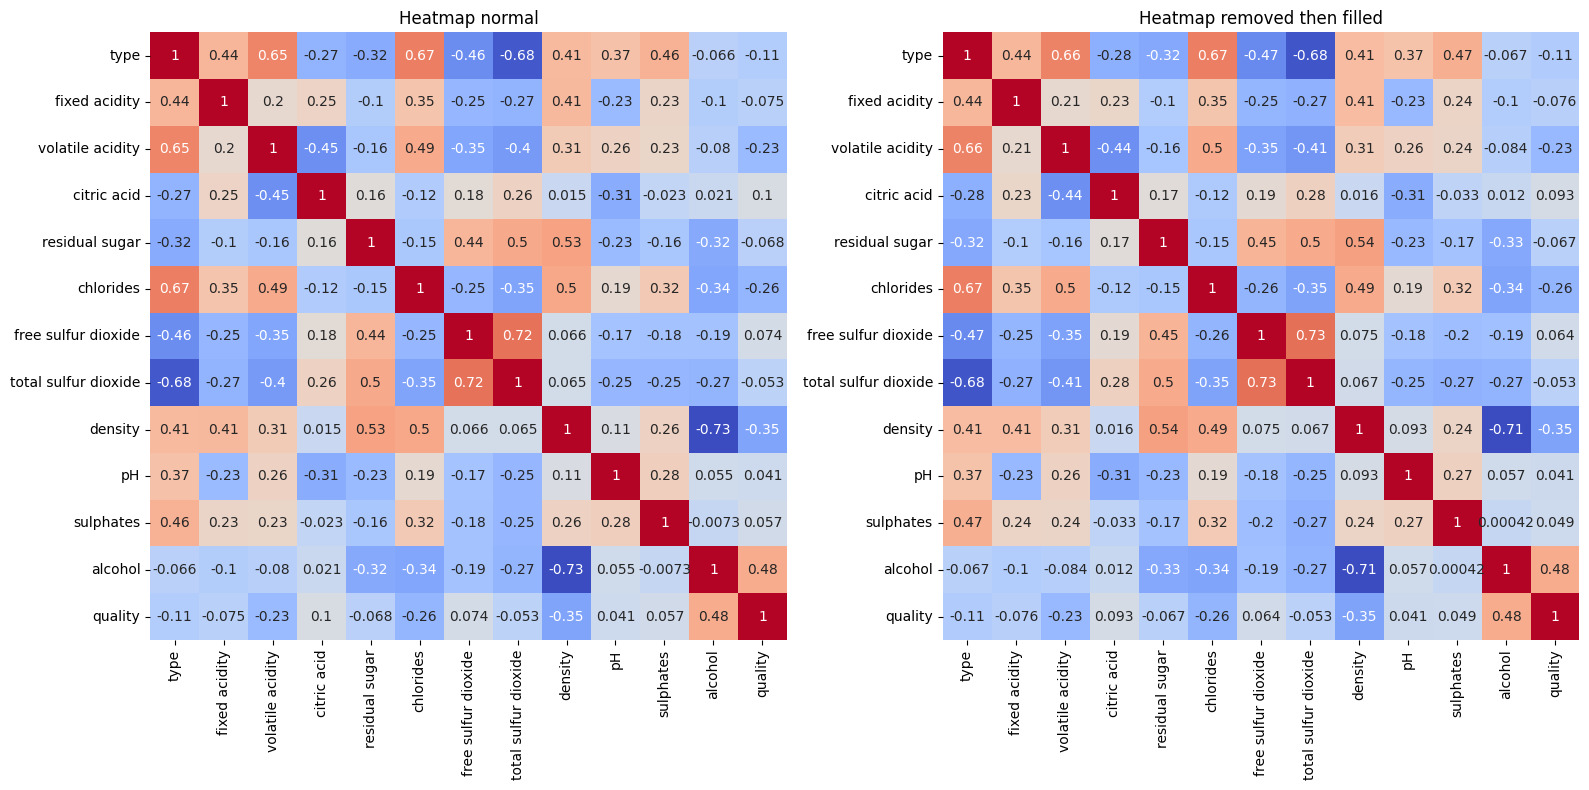

In [25]:
import seaborn as sns

df_1 = X_train_list[2].join(y_train_list[2])
df_2 = X_train_list_rem[2].join(y_train_list_rem[2])

df = [df_1, df_2]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

titles = ['Heatmap normal', 'Heatmap removed then filled']

for ax, df, title in zip(axes, df, titles):
    corr = df.corr()  
    sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, cbar=False)
    ax.set_title(title)
    print(np.round(corr["quality"],3)[0:-1])

plt.tight_layout()
plt.show()

In [26]:
im_gr1 = ['volatile acidity', 'chlorides', 'density', 'alcohol']
im_gr2 = ['type', 'volatile acidity', 'citric acid', 'chlorides', 'density', 'alcohol']
im_gr3 = X.columns

imp_grs = [im_gr1, im_gr2, im_gr3]

# 2. KONSTRUKCIJA, EVALVACIJA IN IZBIRA NAPOVEDNEGA MODELA

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def check_model(model, X_train_list, X_test_list, y_train_list, y_test_list, gr):
    assert len(X_train_list) == len(X_test_list) == len(y_train_list) == len(y_test_list)

    fold_accuracies = []
    fold_f1_scores = []
    fold_precisions = []
    fold_recalls = []

    for i in range(len(X_train_list)):
        X_train = (X_train_list[i])[gr]
        X_test = (X_test_list[i])[gr]
        y_train = y_train_list[i]
        y_test = y_test_list[i]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        fold_accuracies.append(round(accuracy,3))
        fold_f1_scores.append(round(f1,3))
        fold_precisions.append(round(precision,3))
        fold_recalls.append(round(recall,3))
        
    res = {
        "accuracy": round(np.mean(fold_accuracies),3), 
        "f1_score": round(np.mean(fold_f1_scores), 3), 
        "precision": round(np.mean(fold_precisions),3),
        "recall": round(np.mean(fold_recalls),3)
    }
    return res

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, MaxPooling2D, Conv2D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GlobalAveragePooling1D, Reshape, multiply


class BatchLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1} ended. Loss: {logs['loss']}, Accuracy: {logs['accuracy']}")

def create_nn_model1(input_shape):
    model = Sequential([
        Dense(1024, input_shape=(input_shape,), activation='elu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.6),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(7, activation='softmax') 
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def create_nn_model2(input_shape):
    model = Sequential([
        Dense(256, input_shape=(input_shape,), activation='leaky_relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(16, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax') 
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def create_nn_model3(input_shape):
    model = Sequential([
        Dense(256, input_shape=(input_shape,), activation='tanh'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='tanh'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='tanh'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='tanh'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='tanh'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(7, activation='softmax') 
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [29]:
from sklearn.preprocessing import OneHotEncoder

def make_check_nn_model(X_train_lst, X_test_lst, y_train_lst, y_test_lst, gr):
    assert len(X_train_lst) == len(X_test_lst) == len(y_train_lst) == len(y_test_lst)

    fold_accuracies1 = []
    fold_f1_scores1 = []
    fold_precisions1 = []
    fold_recalls1 = []

    fold_accuracies2 = []
    fold_f1_scores2 = []
    fold_precisions2 = []
    fold_recalls2 = []

    fold_accuracies3 = []
    fold_f1_scores3 = []
    fold_precisions3 = []
    fold_recalls3 = []

    for i in range(len(X_train_lst)):
        X_train = (X_train_lst[i])[gr]
        X_test = (X_test_lst[i])[gr]
        y_train = y_train_lst[i] 
        y_test = y_test_lst[i]

        encoder = OneHotEncoder()
        y_train = (encoder.fit_transform(y_train)).toarray()

        model_nn1 = create_nn_model1(X_train.shape[1])
        model_nn2 = create_nn_model2(X_train.shape[1])
        model_nn3 = create_nn_model3(X_train.shape[1])
    
        batch_logger1 = BatchLoggingCallback()
        batch_logger2 = BatchLoggingCallback()
        batch_logger3 = BatchLoggingCallback()

        model_nn1.fit(X_train, y_train, epochs=12, batch_size=750, verbose=0, callbacks=[batch_logger1])
        model_nn2.fit(X_train, y_train, epochs=12, batch_size=750, verbose=0, callbacks=[batch_logger2])
        model_nn3.fit(X_train, y_train, epochs=12, batch_size=750, verbose=0, callbacks=[batch_logger3])

        y_pred_probs1 = model_nn1.predict(X_test)
        y_pred1 = np.argmax(y_pred_probs1, axis=1) + 3
        y_pred_probs2 = model_nn2.predict(X_test)
        y_pred2 = np.argmax(y_pred_probs2, axis=1) + 3
        y_pred_probs3 = model_nn3.predict(X_test)
        y_pred3 = np.argmax(y_pred_probs3, axis=1) + 3

        accuracy1 = accuracy_score(y_test, y_pred1)
        f11 = f1_score(y_test, y_pred1, average='weighted')
        precision1 = precision_score(y_test, y_pred1, average='weighted')
        recall1 = recall_score(y_test, y_pred1, average='weighted')

        print(accuracy1, f11, precision1, recall1)

        accuracy2 = accuracy_score(y_test, y_pred2)
        f12 = f1_score(y_test, y_pred2, average='weighted')
        precision2 = precision_score(y_test, y_pred2, average='weighted')
        recall2 = recall_score(y_test, y_pred2, average='weighted')

        accuracy3 = accuracy_score(y_test, y_pred3)
        f13 = f1_score(y_test, y_pred3, average='weighted')
        precision3 = precision_score(y_test, y_pred3, average='weighted')
        recall3 = recall_score(y_test, y_pred3, average='weighted')

        fold_accuracies1.append(round(accuracy1,3))
        fold_f1_scores1.append(round(f11,3))
        fold_precisions1.append(round(precision1,3))
        fold_recalls1.append(round(recall1,3))

        fold_accuracies2.append(round(accuracy2,3))
        fold_f1_scores2.append(round(f12,3))
        fold_precisions2.append(round(precision2,3))
        fold_recalls2.append(round(recall2,3))

        fold_accuracies3.append(round(accuracy3,3))
        fold_f1_scores3.append(round(f13,3))
        fold_precisions3.append(round(precision3,3))
        fold_recalls3.append(round(recall3,3))
    
    res1 = {
        "accuracy": round(np.mean(fold_accuracies1),3), 
        "f1_score": round(np.mean(fold_f1_scores1), 3), 
        "precision": round(np.mean(fold_precisions1),3),
        "recall": round(np.mean(fold_recalls1),3)
    }
    res2 = {
        "accuracy": round(np.mean(fold_accuracies2),3), 
        "f1_score": round(np.mean(fold_f1_scores2),3), 
        "precision": round(np.mean(fold_precisions2),3),
        "recall": round(np.mean(fold_recalls2),3)
    }
    res3 = {
        "accuracy": round(np.mean(fold_accuracies3),3), 
        "f1_score": round(np.mean(fold_f1_scores3), 3), 
        "precision": round(np.mean(fold_precisions3),3),
        "recall": round(np.mean(fold_recalls3),3)
    }
    res = [res1, res2, res3]
    return res

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import json

models = [
    LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1),
    KNeighborsClassifier(n_neighbors=5)
]

model_names = [     
    "Logistic Regression",
    "Decision Tree Classifier",
    "Random Forest Classifier",
    "Gradient Boosting Classifier",
    "K-Nearest Neighbors Classifier" 
]
for i, gr in enumerate(imp_grs):
    for model, model_name in zip(models, model_names):
        print(f"Evaluating {model_name}...")
        results = check_model(model, X_train_list, X_test_list, y_train_list, y_test_list, gr)

        with open(f"res_{model_name}_{i+1}.txt", 'w') as file:
            json.dump(results, file)

        print("="*80)

for i, gr in enumerate(imp_grs):
    for model, model_name in zip(models, model_names):
        print(f"Evaluating {model_name}...")
        results = check_model(model, X_train_list_rem, X_test_list_rem, y_train_list_rem, y_test_list_rem, gr)

        with open(f"res_{model_name}_{i+1}_rem.txt", 'w') as file:
            json.dump(results, file)

        print("="*80)

for i, gr in enumerate(imp_grs):
    results = make_check_nn_model(X_train_list, X_test_list, y_train_list, y_test_list, gr)

    for j, res in enumerate(results):
        with open(f"res_Neural Network{j+1}_{i+1}.txt", 'w') as file:
            json.dump(res, file)

for i, gr in enumerate(imp_grs):
    results = make_check_nn_model(X_train_list_rem, X_test_list_rem, y_train_list_rem, y_test_list_rem, gr)
    
    for j, res in enumerate(results):
        with open(f"res_Neural Network{j+1}_{i+1}_rem.txt", 'w') as file:
            json.dump(res, file)

Evaluating Logistic Regression...
Evaluating Decision Tree Classifier...
Evaluating Random Forest Classifier...
Evaluating Gradient Boosting Classifier...
Evaluating K-Nearest Neighbors Classifier...
Evaluating Logistic Regression...
Evaluating Decision Tree Classifier...
Evaluating Random Forest Classifier...
Evaluating Gradient Boosting Classifier...
Evaluating K-Nearest Neighbors Classifier...
Evaluating Logistic Regression...
Evaluating Decision Tree Classifier...
Evaluating Random Forest Classifier...
Evaluating Gradient Boosting Classifier...
Evaluating K-Nearest Neighbors Classifier...
Evaluating Logistic Regression...
Evaluating Decision Tree Classifier...
Evaluating Random Forest Classifier...
Evaluating Gradient Boosting Classifier...
Evaluating K-Nearest Neighbors Classifier...
Evaluating Logistic Regression...
Evaluating Decision Tree Classifier...
Evaluating Random Forest Classifier...
Evaluating Gradient Boosting Classifier...
Evaluating K-Nearest Neighbors Classifier...


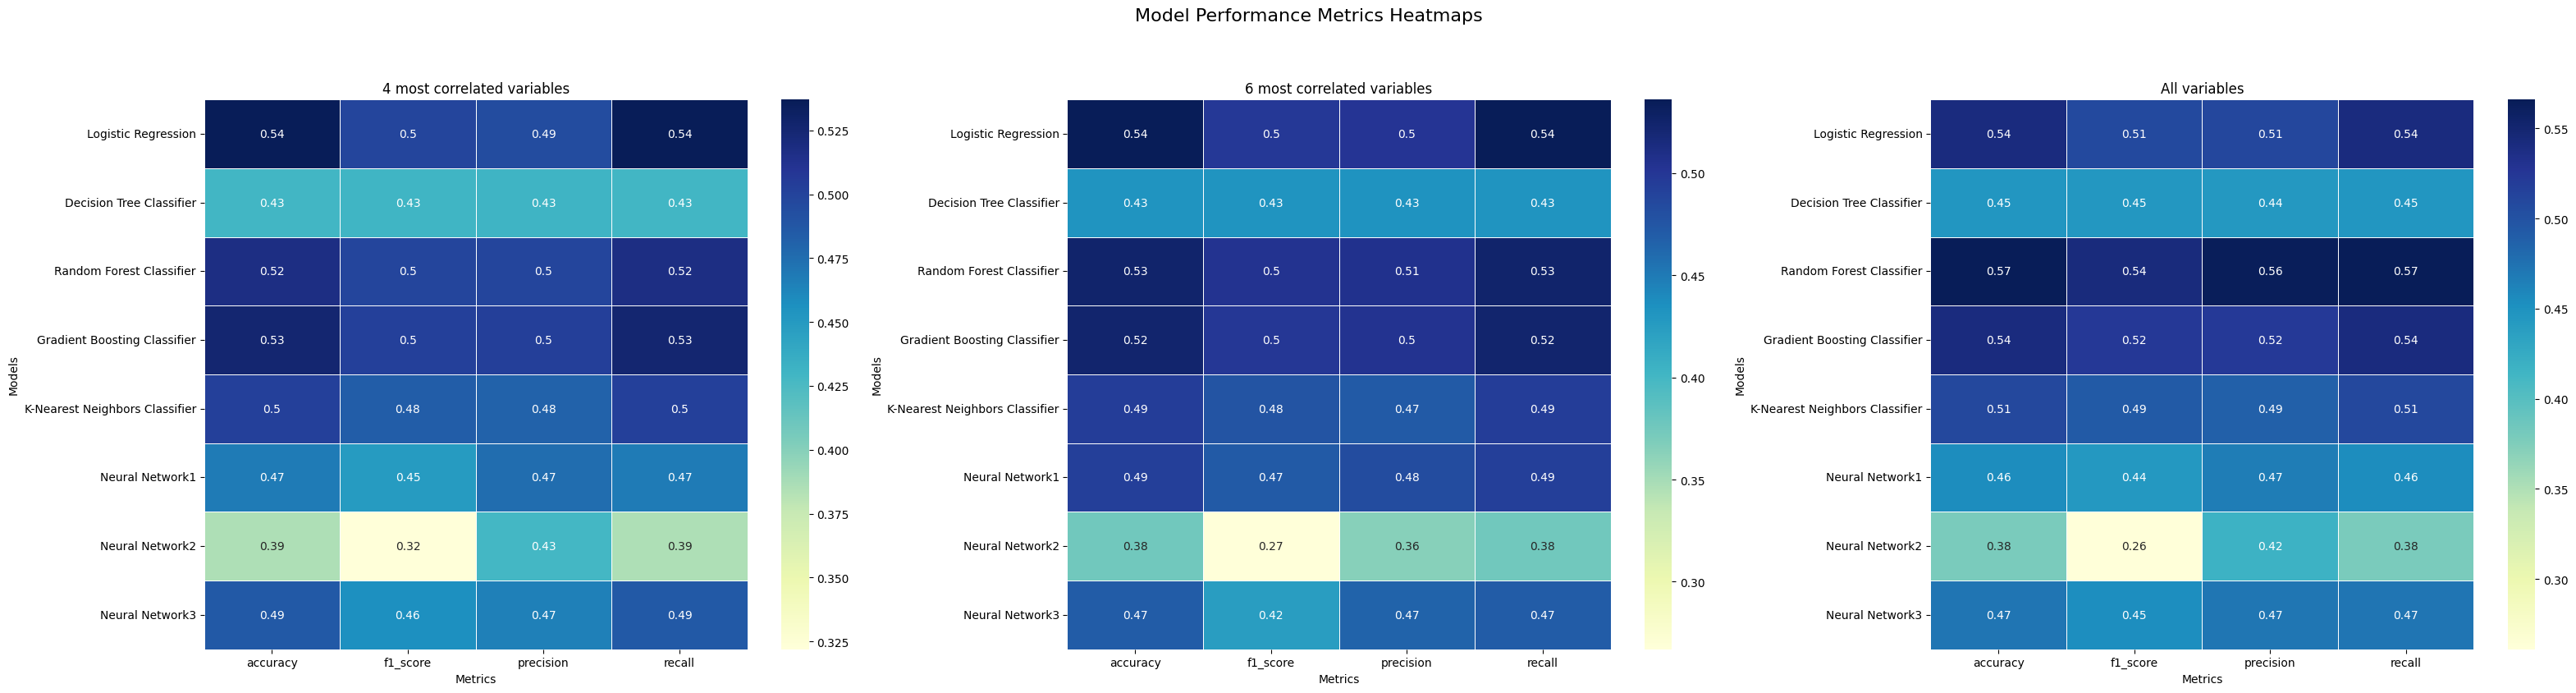

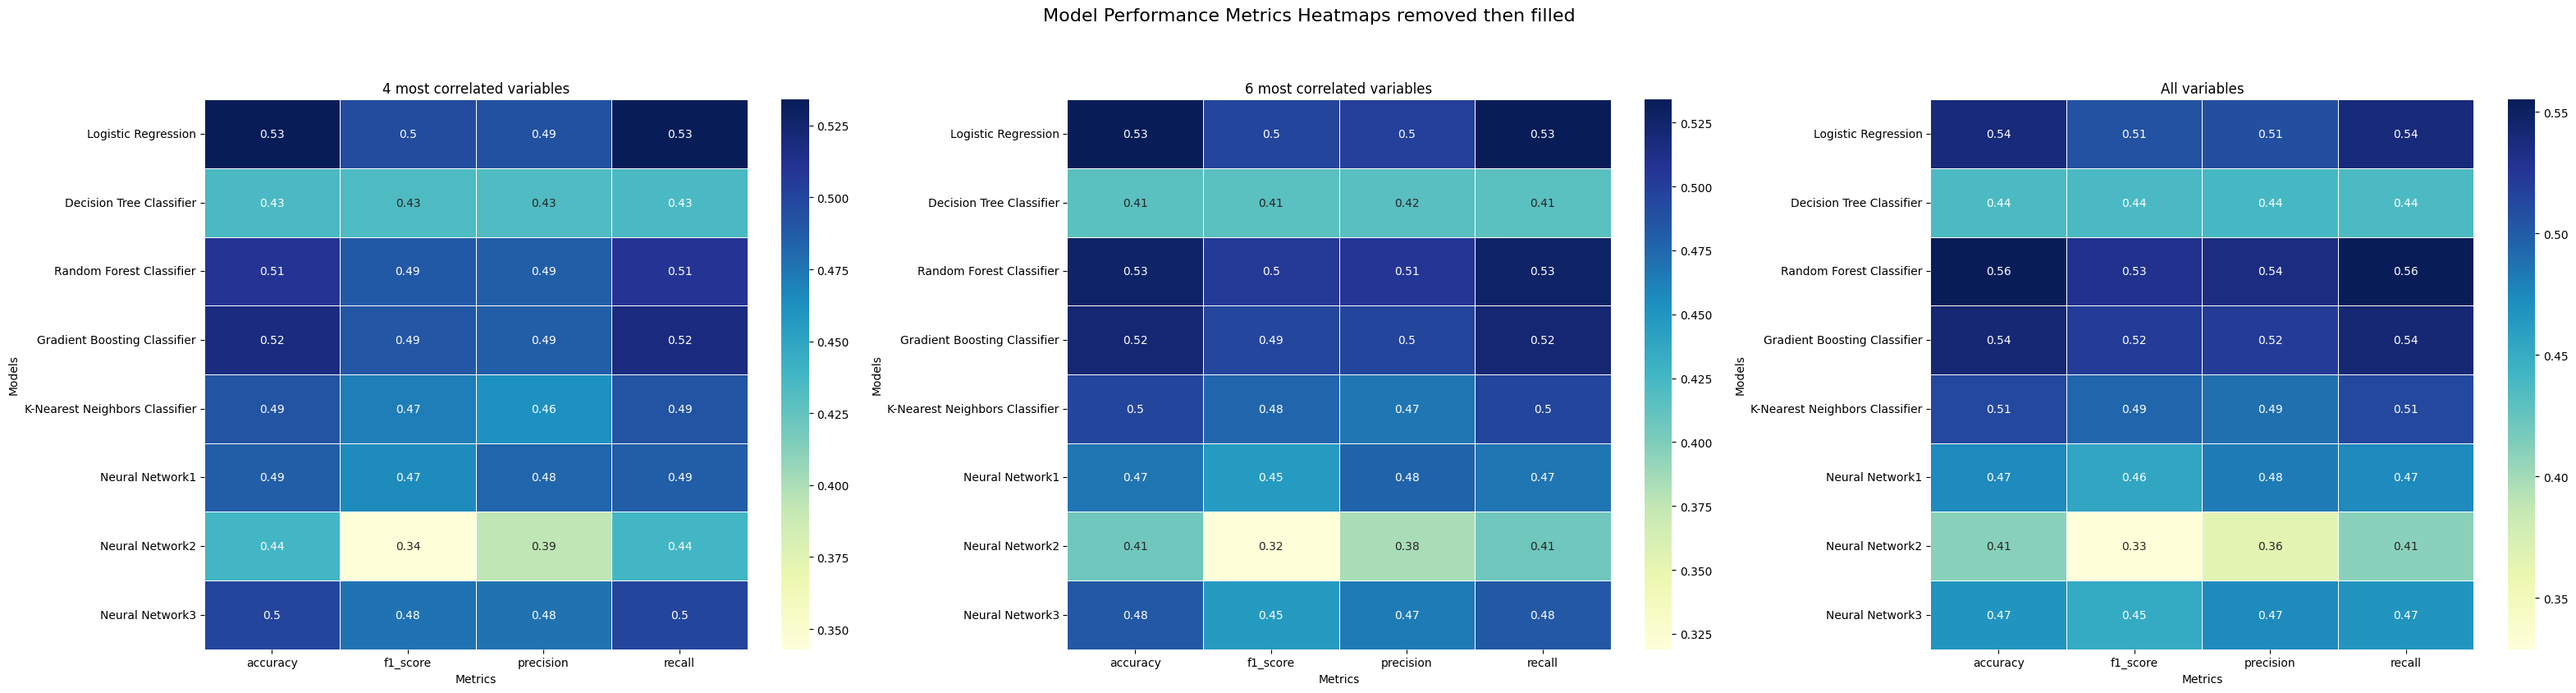

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

lst_rem = []
lst = []

mod_names = [
    "Logistic Regression",
    "Decision Tree Classifier",
    "Random Forest Classifier",
    "Gradient Boosting Classifier",
    "K-Nearest Neighbors Classifier",
    "Neural Network1",
    "Neural Network2",
    "Neural Network3"
]

for i in range(1,4):

    results = {}
    results_rem = {}

    for mod_name in mod_names:
        with open("res_" + f"{mod_name}_" + f"{i}.txt", 'r') as file:
            res = json.load(file)
            results[f"{mod_name}"] = res

        with open("res_" + f"{mod_name}_" + f"{i}_rem.txt", 'r') as file:
            res_rem = json.load(file)
            results_rem[f"{mod_name}"] = res_rem
    
    df_rem = pd.DataFrame(results_rem).transpose()
    df = pd.DataFrame(results).transpose()

    lst.append(df)
    lst_rem.append(df_rem)


fig, axes = plt.subplots(1, 3, figsize=(32, 8))

names_gr = ["4 most correlated variables", "6 most correlated variables", "All variables"]

for j in range(3):
    sns.heatmap(lst[j], annot=True, cmap="YlGnBu", linewidths=.5, ax=axes[j])
    axes[j].set_title(f"{names_gr[j]}")
    axes[j].set_xlabel('Metrics')
    axes[j].set_ylabel('Models')

plt.suptitle('Model Performance Metrics Heatmaps', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(32, 8))

names_gr = ["4 most correlated variables", "6 most correlated variables", "All variables"]

for j in range(3):
    sns.heatmap(lst_rem[j], annot=True, cmap="YlGnBu", linewidths=.5, ax=axes[j])
    axes[j].set_title(f"{names_gr[j]}")
    axes[j].set_xlabel('Metrics')
    axes[j].set_ylabel('Models')

plt.suptitle('Model Performance Metrics Heatmaps removed then filled', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()